# Portfolio Management

## Part 1: Portfolio optimization

Portfolio optimization is a mathematical technique used to construct an optimal investment portfolio that maximizes returns while minimizing risk.

In this project, we will be utilizing the power of mathematical optimization to find the optimal allocation of assets in a portfolio. We will consider factors such as expected returns, volatility, and the sharpe ratio to construct portfolios that strike a balance between risk and reward.

To achieve this, we will employ techniques such as mean-variance optimization and the efficient frontier. These techniques will help us identify the optimal combination of stocks that maximize returns for a given level of risk or minimize risk for a desired level of returns.

In [109]:
# Imports

import cvxpy as cp
import yfinance as yf
import pandas as pd
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import seaborn as sns

In [46]:
# To get a list of tickers, we will scrape the Wikipedia page that contains the list of S&P 500 companies.

def scrape_tickers():
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text.strip()
        tickers.append(ticker)

    return tickers

sp500_tickers = scrape_tickers()
sp500_tickers.count('') # No empty tickers

0

In [47]:
# Download the stock data
data = yf.download(sp500_tickers, start='2020-03-31', end='2024-03-31')

# For this purpose, only the close prices are needed.
prices = data['Adj Close']

[*********************100%%**********************]  503 of 503 completed

4 Failed downloads:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2020-03-31 -> 2024-03-31)')
['GEV', 'SOLV']: Exception("%ticker%: Data doesn't exist for startDate = 1585627200, endDate = 1711857600")


In [48]:
# Drop the columns (tickers) where NA values are found
prices_clean = prices.dropna(axis=1)
prices_clean.isna().sum()

Ticker
A       0
AAL     0
AAPL    0
ABBV    0
ABT     0
       ..
XYL     0
YUM     0
ZBH     0
ZBRA    0
ZTS     0
Length: 494, dtype: int64

In [49]:
# Calculate the returns of the stocks
returns = prices_clean.pct_change().dropna() # dropna to drop the first line with NA values (no return on the first day)

In [51]:
returns.head()

Ticker,A,AAL,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2020-04-01,-0.037699,-0.123052,-0.052617,-0.036356,-0.029654,-0.085734,-0.052554,-0.053513,-0.062019,-0.037237,...,-0.080424,-0.048968,-0.102841,-0.036816,-0.011588,-0.082297,-0.012841,-0.113277,-0.038889,-0.049027
2020-04-02,0.048897,-0.058934,0.016687,0.023291,0.037482,0.011530,0.010279,0.009130,0.042930,0.013582,...,0.014213,-0.017370,-0.024630,0.040289,0.076472,0.060733,-0.023651,0.034363,-0.012581,0.036723
2020-04-03,-0.025868,-0.066600,-0.014372,-0.023426,0.000126,-0.064970,-0.026365,-0.034051,-0.012999,0.009321,...,-0.008333,-0.031566,-0.079172,-0.042370,-0.029455,-0.045741,-0.041635,-0.007550,0.022039,-0.012238
2020-04-06,0.055950,0.011715,0.087237,0.032166,0.041284,0.098334,0.091357,0.086918,0.106747,0.032612,...,0.116303,0.114733,0.169691,0.056862,0.032135,0.077521,0.113744,0.064450,0.077325,0.106274
2020-04-07,-0.004438,0.075790,-0.011582,-0.004490,-0.009670,0.031446,-0.011623,-0.031962,0.004697,0.005590,...,0.018989,0.011111,0.072625,-0.031398,0.019027,0.015340,0.012057,0.040535,0.002658,-0.005363


In [52]:
# Create a function to calculate the portfolio's overall annualized returns and annualized volatility
def calculate_portfolio_performance(weights, returns):
    portfolio_return = np.sum(returns.mean() * weights) * 252
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    return portfolio_return, portfolio_volatility

# Create a function to generate random weights for each stock in the portfolio
def generate_random_weights(number_of_stocks):
    weights = np.random.random(number_of_stocks)
    weights /= np.sum(weights)
    return weights

## A. Monte Carlo & Efficient Frontier

Monte Carlo simulation is a powerful technique for portfolio optimization, leveraging randomness to model and analyze the behavior of asset returns. By simulating thousands of potential future scenarios, it allows us to assess the probabilistic distribution of portfolio returns and risks. The portfolios generated through these simulations are evaluated based on the Sharpe ratio, which measures the excess return per unit of risk, calculated as the portfolio's return minus the risk-free rate, divided by the portfolio's standard deviation. Higher Sharpe ratios indicate more efficient portfolios. After evaluating the Sharpe ratios, the efficient frontier is plotted, representing the set of optimal portfolios offering the highest expected return for a given level of risk. Inspecting the efficient frontier helps in visualizing the trade-off between risk and return, guiding investors in selecting the most suitable asset allocation.

In [74]:
# Get the stock names
stock_names = prices_clean.columns

# Run a Monte Carlo simulation to generate a large number of random portfolios
number_of_portfolios = 10000
number_of_stocks = len(stock_names)

# Initialize a list to store the portfolio data
portfolios = []

for _ in range(number_of_portfolios):
    weights = generate_random_weights(number_of_stocks)
    portfolio_return, portfolio_volatility = calculate_portfolio_performance(weights, returns)
    
    # Create a dictionary to store the data for this portfolio
    portfolio_data = {'return': portfolio_return, 'volatility': portfolio_volatility}
    
    # Add the weights to the dictionary
    for i in range(number_of_stocks):
        portfolio_data[stock_names[i]] = weights[i]
    
    # Append the dictionary to the list
    portfolios.append(portfolio_data)

In [76]:
# Convert the list of dictionaries to a DataFrame
portfolios = pd.DataFrame(portfolios)

# Calculate the Sharpe Ratios for the portfolios
portfolios['sharpe_ratio'] = portfolios['return'] / portfolios['volatility']

# Find the portfolio with the highest Sharpe Ratio
max_sharpe_ratio_index = portfolios['sharpe_ratio'].idxmax()

In [77]:
portfolios['sharpe_ratio'].iloc[max_sharpe_ratio_index]

1.332418014662906

In [78]:
portfolios.head()

,return,volatility,A,AAL,AAPL,ABBV,ABT,ACGL,ACN,ADBE,...,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS,sharpe_ratio
0,0.248585,0.194124,0.001408,0.001012,0.002390,0.001969,1.522276e-03,0.003282,0.001964,0.001863,...,0.002380,0.002226,0.003123,0.001442,0.004117,0.002478,0.003972,0.000319,0.001260,1.280547
1,0.250270,0.194858,0.003930,0.004076,0.000008,0.001990,4.761632e-04,0.000450,0.002682,0.000893,...,0.002440,0.000357,0.001475,0.002570,0.002712,0.000811,0.002232,0.002735,0.000782,1.284369
2,0.251966,0.195208,0.002740,0.002223,0.003483,0.003527,1.581268e-03,0.002256,0.002304,0.000431,...,0.000984,0.002878,0.002987,0.002947,0.000885,0.002232,0.001470,0.000376,0.003107,1.290760
3,0.249813,0.195761,0.002489,0.001902,0.003755,0.002696,1.998176e-07,0.000651,0.003487,0.003747,...,0.000456,0.000229,0.003470,0.002887,0.002425,0.002998,0.003524,0.000575,0.001974,1.276108
4,0.249599,0.195311,0.001312,0.000590,0.002607,0.002870,2.194391e-03,0.003461,0.000451,0.003548,...,0.003610,0.001033,0.003007,0.001334,0.001812,0.003155,0.003517,0.002017,0.002295,1.277956


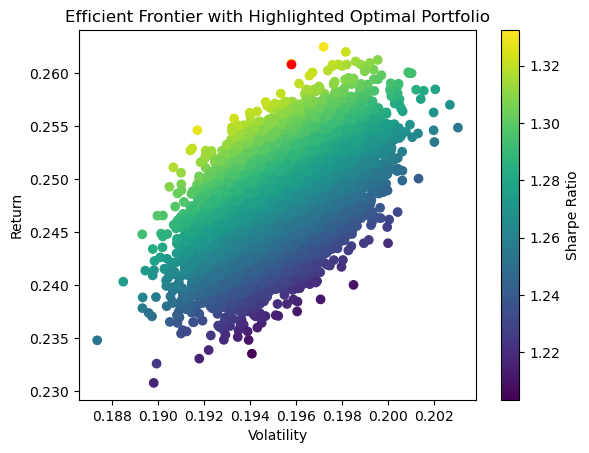

In [79]:
# Plot the simulated portfolios
plt.scatter(portfolios['volatility'], portfolios['return'], c=portfolios['sharpe_ratio'], cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

# Highlight the portfolio with the highest Sharpe Ratio
plt.scatter(portfolios.loc[max_sharpe_ratio_index, 'volatility'], portfolios.loc[max_sharpe_ratio_index, 'return'], color='r')
plt.title('Efficient Frontier with Highlighted Optimal Portfolio')

plt.show()

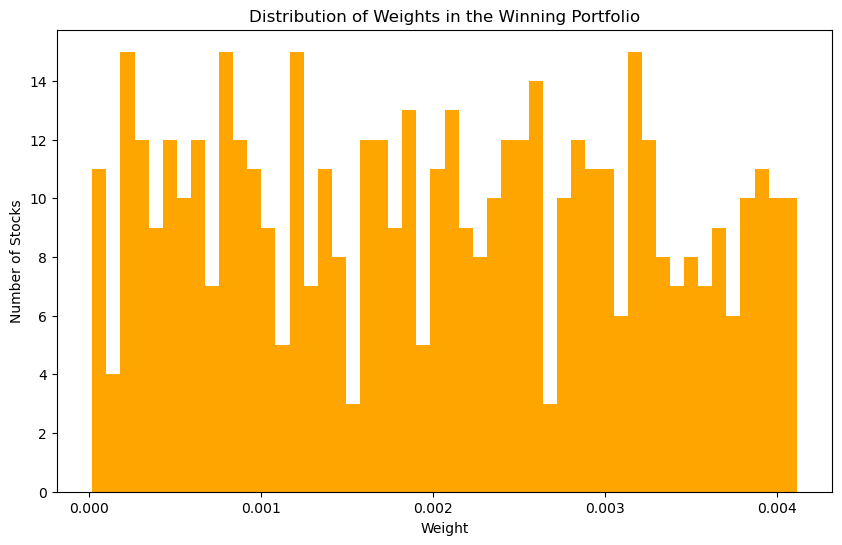

In [96]:
# Find the portfolio with the highest return
winning_portfolio = portfolios.iloc[max_sharpe_ratio_index]

# Remove the 'return' and 'volatility' entries
winning_weights = winning_portfolio.drop(['return', 'volatility','sharpe_ratio'])

winning_weights.hist(bins=50, figsize=(10, 6),grid=False, color='orange')
plt.title('Distribution of Weights in the Winning Portfolio')
plt.xlabel('Weight')
plt.ylabel('Number of Stocks')
plt.show()

## B. Objective functions

### 1. SLSQP (Sequential Least Squares Programming)

Sequential Least Squares Programming (SLSQP) is an optimization algorithm used to solve constrained optimization problems.

In simple terms, SLSQP aims to find the values of variables that minimize or maximize an objective function while satisfying a set of constraints. The algorithm iteratively adjusts the values of the variables to find the optimal solution.

Minimize (or Maximize) f(x)

Subject to:
g(x) <= 0
h(x) = 0

Where:
- f(x) is the objective function that we want to minimize or maximize.
- g(x) represents the inequality constraints.
- h(x) represents the equality constraints.
- x is a vector of variables that we need to find the optimal values for.

The SLSQP algorithm works by iteratively approximating the solution using a **quadratic approximation** of the objective function and the constraints. It starts with an initial guess for the values of the variables and then iteratively updates them until convergence is achieved.

During each iteration, SLSQP solves a quadratic programming subproblem to find the search direction and step size for updating the variables. It takes into account the gradients and Hessians of the objective function and the constraints to guide the search.

The algorithm continues iterating until it reaches a point where the variables no longer change significantly, indicating that an optimal solution has been found (or until a maximum number of iterations is reached).

In [97]:
# Calculate returns from price data
returns = prices_clean.pct_change().dropna()


# Define the objective function (negative Sharpe Ratio)
def objective(weights):
    portfolio_return = np.sum(returns.mean() * weights) * 252
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    sharpe_ratio = portfolio_return / portfolio_volatility
    return -sharpe_ratio  # We negate because we want to maximize the Sharpe Ratio

# Define the constraints (weights must sum to 1)
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

number_of_stocks= prices_clean.shape[1]

# Define the bounds (weights must be between 0 and 1 because we wont short)
bounds = tuple((0, 1) for _ in range(number_of_stocks))

# Initial guess for the weights (equal distribution)
init_guess = np.array(number_of_stocks * [1. / number_of_stocks,])

# Define a callback function to print out the current state
def print_state(x):
    print(f"Current weights: {x}")
    print(f"Current objective function value: {objective(x)}")

# Run the optimizer
result = minimize(objective, init_guess, method='SLSQP', bounds=bounds, constraints=constraints, options={'ftol': 1e-06}, callback=print_state)

# The optimal weights are in result.x
optimal_weights = result.x

Current weights: [0.00000000e+00 0.00000000e+00 6.11368595e-14 1.54447635e-13
 0.00000000e+00 6.18689128e-15 5.43285035e-14 0.00000000e+00
 7.34872233e-15 2.25073866e-13 1.36609474e-15 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.48978919e-13 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.09080280e-13 7.63928851e-15
 2.71180647e-15 0.00000000e+00 8.03016507e-14 1.45998665e-14
 3.88948856e-13 2.84776543e-13 0.00000000e+00 0.00000000e+00
 1.50302513e-13 0.00000000e+00 6.06389938e-14 3.72813759e-14
 2.95592977e-13 4.67100317e-14 5.65311686e-14 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.59729868e-13
 0.00000000e+00 0.00000000e+00 1.11355369e-13 0.00000000e+00
 1.86272005e-13 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.40936741e-13 0.00000000e+00 0.00000000e+00
 1.40677400e-13 4.02512225e-14 0.00000000e+00 7.96094961e-14
 0.00000000e+00 0.00000000e+00 1.37282980e-13 2.68487923e-13
 3.5954

In [101]:
print("The sharpe ratio is {}".format(-result.fun))

The sharpe ratio is 2.874569811951174


A sharpe ratio of 2.87 is a very good result and already a big improvement from the optimal portfolio obtained from monte carlo simulations.

### 2. L-BFGS-B

The BFGS (Broyden-Fletcher-Goldfarb-Shanno) method is an optimization algorithm used to solve unconstrained optimization problems. It belongs to the class of quasi-Newton methods, which aim to find the minimum of a function without explicitly computing its derivatives.

The BFGS method approximates the Hessian matrix of the objective function using a series of rank-one updates. The Hessian matrix represents the second-order derivatives of the objective function and provides information about the curvature of the function's surface. By iteratively updating the approximation of the Hessian matrix, the BFGS method converges towards the minimum of the function.

The BFGS method is known for its good convergence properties and is widely used in optimization problems. It combines the benefits of gradient-based methods (which use first-order derivatives) and Newton's method (which uses second-order derivatives) by approximating the Hessian matrix without explicitly computing it.

The L-BFGS-B variant is a limited-memory version of the BFGS method that is specifically designed for solving optimization problems with bound constraints. The "L" in L-BFGS-B stands for "limited-memory," which means that it stores a limited number of past iterations to approximate the Hessian matrix.

The L-BFGS-B variant is particularly useful when dealing with large-scale optimization problems where the Hessian matrix is too expensive to compute or store. It uses a limited-memory approach to approximate the Hessian matrix efficiently, making it suitable for problems with a large number of variables.

In addition to the BFGS updates, the L-BFGS-B variant also incorporates bound constraints into the optimization process. Bound constraints restrict the values of the variables within a specified range. The L-BFGS-B method ensures that the optimization process respects these constraints and finds the optimal solution within the given bounds.

In [107]:
# Calculate returns from price data
returns = prices_clean.pct_change().dropna()


# Define the objective function (negative Sharpe Ratio)
def objective(weights):
    portfolio_return = np.sum(returns.mean() * weights) * 252
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    sharpe_ratio = portfolio_return / portfolio_volatility
    return -sharpe_ratio  # We negate because we want to maximize the Sharpe Ratio

number_of_stocks= prices_clean.shape[1]

# Define the bounds (weights must be between 0 and 1 because we wont short)
bounds = tuple((0, 1) for _ in range(number_of_stocks))

# Initial guess for the weights (equal distribution)
init_guess = np.array(number_of_stocks * [1. / number_of_stocks,])

# Define a callback function to print out the current state
def print_state(x):
    print(f"Current weights: {x}")
    print(f"Current objective function value: {objective(x)}")

# Run the optimizer
result = minimize(objective, init_guess, method='L-BFGS-B', bounds=bounds, options={'ftol': 1e-06}, callback=print_state)

# The optimal weights are in result.x
optimal_weights = result.x

# Normalize the weights so they sum to 1 since this method does not support constraints
optimal_weights = optimal_weights / np.sum(optimal_weights)

Current weights: [0.         0.         0.38935897 0.96102148 0.         0.5315308
 0.         0.         0.         0.0955533  0.         0.
 0.         0.         0.         0.26802984 0.30794049 0.07616105
 0.68038182 0.         0.         0.         0.14650496 0.
 0.63540557 0.         0.79182998 0.19094779 0.19468873 0.43246464
 0.         0.         1.         0.         0.14290049 0.13070662
 1.         0.         0.30435883 0.         0.         0.
 0.         1.         0.         0.         1.         0.
 1.         0.         0.         0.         0.         0.95338963
 0.         0.         0.         0.51478466 0.         0.
 0.         0.05614762 0.61055314 1.         0.         0.
 0.1941983  0.26177345 0.04442775 0.         0.09351668 0.
 0.         0.         0.59584653 0.65217836 0.50338291 0.3019883
 0.5244573  0.         0.         0.         1.         0.11787415
 0.         0.75189805 0.         0.47699793 0.         0.
 0.33469689 0.         0.13899011 0.        

In [108]:
print("The sharpe ratio is {}".format(-result.fun))

The sharpe ratio is 2.073329173777189


### 3. CVXPY - ECOS solver

The ECOS solver is an optimization solver that is commonly used for solving convex optimization problems. It stands for Embedded Conic Solver and is based on the second-order cone programming (SOCP) framework.

The ECOS solver is designed to solve optimization problems of the form:

minimize c^T * x

subject to A * x = b

G * x <= h



where `x` is the optimization variable, `c` is the cost vector, `A` and `G` are matrices, `b` and `h` are vectors.

The ECOS solver utilizes the conic programming approach, which allows it to handle a wide range of convex optimization problems efficiently. It can handle linear constraints, second-order cone constraints, and exponential cone constraints.

The algorithm used by ECOS is an interior-point method, specifically a primal-dual interior-point method. This method iteratively solves a sequence of barrier subproblems, which are optimization problems with a logarithmic barrier term added to the objective function. The barrier term ensures that the iterates stay within the feasible region.

At each iteration, the solver computes search directions for the primal and dual variables, updates the iterates, and checks for convergence. The process continues until a stopping criterion is met, such as reaching a desired level of accuracy or the maximum number of iterations.

In [115]:
target_volatility= 0.15


# Define the weights variable
weights = cp.Variable(number_of_stocks)

# Define the objective function
portfolio_return = np.array(returns.mean()) * weights * 252
portfolio_volatility = cp.quad_form(weights, returns.cov() * 252)

# Define the constraints
constraints = [cp.sum(weights) == 1, 
               weights >= 0, 
               weights <= 1, 
               portfolio_volatility <= target_volatility**2]  # Add a constraint on the portfolio volatility

# Define the problem and solve it using the ECOS solver
problem = cp.Problem(cp.Maximize(portfolio_return), constraints)
problem.solve(solver=cp.ECOS)

# The optimal weights are in weights.value
optimal_weights = weights.value

# Calculate the portfolio return and volatility with the optimal weights
optimal_return = np.sum(returns.mean() * optimal_weights) * 252
optimal_volatility = np.sqrt(np.dot(optimal_weights.T, np.dot(returns.cov() * 252, optimal_weights)))

# Calculate the Sharpe ratio
sharpe_ratio = optimal_return / optimal_volatility

/Users/mxvp/anaconda3/envs/optimization_course/lib/python3.12/site-packages/cvxpy/expressions/expression.py:621: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 4 times so far.

  warnings.warn(msg, UserWarning)


In [117]:
print("The sharpe ratio is {}".format(sharpe_ratio))

The sharpe ratio is 2.733336834744075


## Part 2: Optimal Order Execution

Optimal order execution is a critical aspect of trading in financial markets. It involves the process of executing a large order in the most efficient and cost-effective manner possible. In part 2 of my project, I focused on developing a framework for optimizing order execution strategies.

The goal of optimal order execution is to minimize the impact of the order on the market while achieving the best possible execution price. This requires careful consideration of various factors such as market liquidity, trading volume, price volatility, and transaction costs.

I also incorporated advanced order types such as limit orders, market orders, and stop orders to optimize execution. Limit orders allow traders to specify a maximum or minimum price at which they are willing to buy or sell, ensuring that the order is executed at a favorable price. Market orders, on the other hand, execute the order immediately at the prevailing market price. Stop orders are used to trigger an order when the market reaches a certain price level, helping to limit losses or capture profits.

In [ ]:
# Simulate dynamic orderbook

import numpy as np
import pandas as pd

# Define the initial state of the order book
order_book = pd.DataFrame({
    'bid_price': np.arange(99, 89, -1),
    'bid_size': np.random.randint(1, 10, 10),
    'ask_price': np.arange(101, 111),
    'ask_size': np.random.randint(1, 10, 10),
})

# Function to generate a new order
def generate_order(order_book):
    # Choose a side (buy or sell)
    side = np.random.choice(['bid', 'ask'])
    
    # Choose a price level
    price_level = np.random.randint(0, 10)
    
    # Choose a size
    size = np.random.randint(1, 10)
    
    # Add the order to the order book
    if side == 'bid':
        order_book.loc[price_level, 'bid_size'] += size
    else:
        order_book.loc[price_level, 'ask_size'] += size

# Function to cancel an order
def cancel_order(order_book):
    # Choose a side (buy or sell)
    side = np.random.choice(['bid', 'ask'])
    
    # Choose a price level
    price_level = np.random.randint(0, 10)
    
    # Reduce the size of the order at the chosen price level
    if side == 'bid':
        order_book.loc[price_level, 'bid_size'] = max(0, order_book.loc[price_level, 'bid_size'] - 1)
    else:
        order_book.loc[price_level, 'ask_size'] = max(0, order_book.loc[price_level, 'ask_size'] - 1)

# Function to execute a market order
def execute_market_order(order_book):
    # Choose a side (buy or sell)
    side = np.random.choice(['bid', 'ask'])
    
    # Execute the order at the best price
    if side == 'bid':
        # Find the best ask (lowest price)
        best_ask = order_book['ask_price'].idxmin()
        
        # Reduce the size of the best ask by 1
        order_book.loc[best_ask, 'ask_size'] = max(0, order_book.loc[best_ask, 'ask_size'] - 1)
    else:
        # Find the best bid (highest price)
        best_bid = order_book['bid_price'].idxmax()
        
        # Reduce the size of the best bid by 1
        order_book.loc[best_bid, 'bid_size'] = max(0, order_book.loc[best_bid, 'bid_size'] - 1)

# Simulate the dynamic order book
for _ in range(100):
    action = np.random.rand()
    
    # Generate a new limit order with a 60% probability
    if action < 0.6:
        generate_order(order_book)
    
    # Cancel an existing limit order with a 20% probability
    elif action < 0.8:
        cancel_order(order_book)
    
    # Execute a market order with a 20% probability
    else:
        execute_market_order(order_book)


print(order_book)

In [ ]:
import cvxpy as cp

# Define the size of the order
order_size = 1000

# Define the execution horizon
horizon = 100

# Estimate the trading volume at each time step
volume_estimate = np.array([100 * (i/horizon)**2 for i in range(horizon)])

# Define the decision variables
trades = cp.Variable(horizon)

# Define the objective function
objective = cp.Minimize(cp.sum_squares(trades - order_size * volume_estimate / volume_estimate.sum()))

# Define the constraints
constraints = [
    # Volume constraint
    cp.sum(trades) == order_size,
    
    # Market impact constraint
    trades <= 0.1 * volume_estimate,
    
    # Non-negativity constraint
    trades >= 0
]

# Define the problem
problem = cp.Problem(objective, constraints)

# Solve the problem
problem.solve()

# Print the optimal trades
print(trades.value)